In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from credentials import Credentials as cr
from prediction import ImmothepPrediction
import os
from split import Splitter
from sklearn.ensemble import IsolationForest

splitter = Splitter()
predictor = ImmothepPrediction()

## Création et import du jeu de données principal

In [ ]:
valeurs2019 = pd.read_csv(cr.PATH+'2019.txt', sep='|', usecols=['Nature mutation', 'Code postal','Nombre pieces principales', 'Surface terrain', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Valeur fonciere', 'Type local', 'Nombre de lots'], encoding='utf-8')

valeurs2019 = valeurs2019.dropna(subset = ['Type local', 'Nombre de lots', 'Nombre pieces principales', "Nature mutation"])

valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)] = valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)].fillna(0) 

valeurs2019 = valeurs2019[['Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Valeur fonciere']][valeurs2019['Type local'].str.contains("Appartement|Maison", regex=True)][valeurs2019['Nature mutation'].str.contains("Vente", regex=True)][valeurs2019['Nombre de lots']<6][valeurs2019['Nombre pieces principales']>0]

valeurs2019.head()

In [ ]:
# Vérification du ratio de valeurs nulles en vue de nettoyer les données.

nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Valeur fonciere'])
nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")

nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Code postal'])
nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")


In [ ]:
valeurs2019.info()

In [ ]:
valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']] = valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']].replace(',', '.', regex=True)

valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']]  = valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']].astype('float')

In [ ]:
valeurs2019.info()

In [ ]:
corrMatrix = valeurs2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
valeurs2019 = valeurs2019[valeurs2019['Valeur fonciere']>200]

In [ ]:
nancount = valeurs2019["Surface terrain"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Surface Terrain\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Surface terrain'])

nancount = valeurs2019["Surface terrain"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Surface Terrain\'.")

valeurs2019 = valeurs2019.fillna(0)

In [ ]:
corrMatrix = valeurs2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Test de la prédiction de la valeur foncière sur l'élémant d'index 5 de valeurs2019

In [ ]:
predictor = ImmothepPrediction()

try:
    result = predictor.predict(valeurs2019, 5)
except : 
    print('Elément non trouvé.')

### Modification du modèle avec méthode d'entraînement et méthode de test

In [ ]:
modele, scaler, lab_enc = predictor.entrainementLR(valeurs2019)

result = predictor.predictionLR(valeurs2019[valeurs2019.index==693], modele, scaler, lab_enc)

In [ ]:
predictor.predictionLR(valeurs2019[valeurs2019.index==10], modele, scaler, lab_enc)

### Modification du dataset pour rendre la prédiction plus précise

In [ ]:
valeurs2019.plot.scatter("Surface terrain", "Valeur fonciere")

In [ ]:
valeurs2019 = valeurs2019[valeurs2019['Valeur fonciere']<60000000]
valeurs2019 = valeurs2019[valeurs2019['Surface terrain']<400000]

In [ ]:
valeurs2019.plot.scatter("Surface terrain", "Valeur fonciere")

### Nouveau test de prédiction

In [ ]:
modele, scaler, lab_enc = predictor.entrainementLR(valeurs2019)

In [ ]:
predictor.predictionLR(valeurs2019[valeurs2019.index==5], modele, scaler, lab_enc)

In [ ]:
predictor.predict(valeurs2019, 5)

In [ ]:
predictor.predict(valeurs2019, 693)

In [ ]:
predictor.predictionLR(valeurs2019[valeurs2019.index==693], modele, scaler, lab_enc)

### Export du premier dataset de travail

In [ ]:
valeurs2019.to_csv(cr.CURATED_LOCAL_PATH + 'filtered2019.csv', index=False)

## Création d'un nouveau dataset avec des attributs différents

In [2]:
valeurs2019 = pd.read_csv(cr.PATH+'2019.txt', sep='|', usecols=['Nature mutation', 'Code postal','Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere', 'Type local', 'Nombre de lots'], encoding='utf-8')

valeurs2019 = valeurs2019.dropna(subset = ['Type local', 'Nombre de lots', 'Nombre pieces principales', 'Nature mutation', 'Surface reelle bati'])

valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)] = valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)].fillna(0) 

valeurs2019 = valeurs2019[['Type local', 'Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere']][valeurs2019['Type local'].str.contains("Appartement|Maison", regex=True)][valeurs2019['Nature mutation'].str.contains("Vente", regex=True)][valeurs2019['Nombre de lots']<2][valeurs2019['Nombre pieces principales']>0]

valeurs2019.head()


,Type local,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere
0,Appartement,1000.0,1.0,0.0,20.0,"37220,00"
3,Maison,1160.0,4.0,940.0,90.0,"209000,00"
4,Maison,1370.0,5.0,490.0,101.0,"134900,00"
5,Maison,1340.0,4.0,708.0,88.0,"192000,00"
6,Maison,1250.0,2.0,631.0,39.0,"45000,00"


In [3]:
# Vérification du ratio de valeurs nulles en vue de nettoyer les données.

nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Valeur fonciere'])
nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")

nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Code postal'])
nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")


Il y a  3531  valeurs nulles dans la colonne 'Valeur Foncière'.
Il y a  0  valeurs nulles dans la colonne 'Valeur Foncière'.
Il y a  51  valeurs nulles dans la colonne 'Code postal'.
Il y a  0  valeurs nulles dans la colonne 'Code postal'.


In [9]:
valeurs2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788108 entries, 0 to 2535786
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Type local                 788108 non-null  object 
 1   Code postal                788108 non-null  float64
 2   Nombre pieces principales  788108 non-null  float64
 3   Surface terrain            768808 non-null  float64
 4   Surface reelle bati        788108 non-null  float64
 5   Valeur fonciere            788108 non-null  object 
dtypes: float64(4), object(2)
memory usage: 42.1+ MB


In [4]:
valeurs2019[['Valeur fonciere']] = valeurs2019[['Valeur fonciere']].replace(',', '.', regex=True)

valeurs2019[['Valeur fonciere']]  = valeurs2019[['Valeur fonciere']].astype('float')

In [5]:
valeurs2019 = valeurs2019[valeurs2019['Valeur fonciere']>10000]
valeurs2019 = valeurs2019[valeurs2019['Valeur fonciere']<60000000]
valeurs2019 = valeurs2019[valeurs2019['Surface terrain']<400000]

nancount = valeurs2019["Surface terrain"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Surface Terrain\'.")

Il y a  0  valeurs nulles dans la colonne 'Surface Terrain'.


In [6]:
maisons2019=valeurs2019[['Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere']][valeurs2019['Type local'].str.contains("Maison", regex=True)].reset_index(drop=True)

appart2019=valeurs2019[['Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere']][valeurs2019['Type local'].str.contains("Appartement", regex=True)][valeurs2019['Surface reelle bati']>9].reset_index(drop=True)

### Création d'une forêt d'isolation en vue d'écarter les valeurs erronées 

In [19]:
anomaly = predictor.isolationforest(maisons2019)
anomaly.head()

,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere,scores,anomaly
46,1960.0,6.0,2999.0,140.0,702200.0,-0.099708,-1
106,1440.0,3.0,3875.0,95.0,2040000.0,-0.287545,-1
128,1190.0,1.0,115.0,50.0,30000.0,-0.025435,-1
140,1560.0,1.0,813.0,60.0,28000.0,-0.032207,-1
141,1560.0,1.0,1154.0,60.0,28000.0,-0.032207,-1


In [9]:
maisonsmerge = maisons2019.merge(anomaly["anomaly"], how="left", right_index=True, left_index=True)
maisonsmerge.head()

,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere,scores,anomaly_x,anomaly_y
0,1160.0,4.0,940.0,90.0,209000.0,0.099751,1,NaN
1,1370.0,5.0,490.0,101.0,134900.0,0.117392,1,NaN
2,1340.0,4.0,708.0,88.0,192000.0,0.102882,1,NaN
3,1250.0,2.0,631.0,39.0,45000.0,0.024918,1,NaN
4,1560.0,1.0,2103.0,100.0,116000.0,0.108527,1,NaN


In [11]:
maisonsfinal = maisonsmerge.drop(maisonsmerge[(maisonsmerge.anomaly_x == -1) & (maisonsmerge.anomaly_y == -1)].index)
maisonsfinal = maisonsfinal.drop(['scores', 'anomaly_x', 'anomaly_y'], axis=1)
maisonsfinal.head()


,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere
0,1160.0,4.0,940.0,90.0,209000.0
1,1370.0,5.0,490.0,101.0,134900.0
2,1340.0,4.0,708.0,88.0,192000.0
3,1250.0,2.0,631.0,39.0,45000.0
4,1560.0,1.0,2103.0,100.0,116000.0


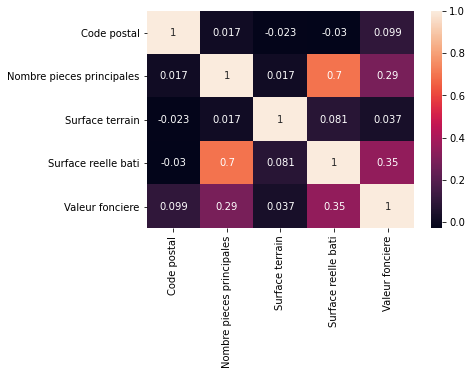

In [12]:
corrMatrix = maisonsfinal.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
anomaly2 = predictor.isolationforest(appart2019)
appartmerge = appart2019.merge(anomaly2["anomaly"], how="left", right_index=True, left_index=True)
appartfinal = appartmerge.drop(appartmerge[(appartmerge.anomaly_x == -1) & (appartmerge.anomaly_y == -1)].index)
appartfinal = appartfinal.drop(['scores', 'anomaly_x', 'anomaly_y'], axis=1)
appartfinal.head()

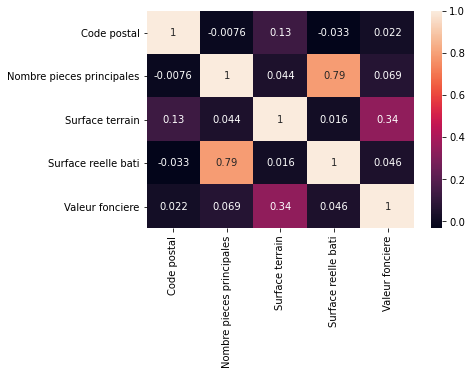

In [13]:
corrMatrix = appart2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [16]:
maisons2019.to_csv(cr.CURATED_LOCAL_PATH + 'filteredmaisons2019.csv', index=False)
appart2019.to_csv(cr.CURATED_LOCAL_PATH + 'filteredappart2019.csv', index=False)

In [ ]:
maisons2019 = pd.read_csv(cr.CURATED_LOCAL_PATH + 'filteredmaisons2019.csv', sep=",")
appart2019 = pd.read_csv(cr.CURATED_LOCAL_PATH + 'filteredappart2019.csv', sep=",")


In [ ]:
modele_lineaire_appart = predictor.trainLinearLeRetour(appart2019)

In [ ]:
predictor.predictionLinear(appart2019[appart2019.index==28], modele_lineaire_appart)

In [17]:
# Split des données par type de logement et par département
splitter.split_datas('filteredmaisons2019.csv', 'Code postal', 'CPMaisons')
splitter.split_datas('filteredappart2019.csv', 'Code postal', 'CPAppart')

In [ ]:
maisonsavendre = pd.read_csv(cr.CURATED_LOCAL_PATH+'CPMaisons/63.csv')
maisonsavendre = maisonsavendre.dropna()

In [ ]:
modeleL = predictor.trainLinearLeRetour(maisonsavendre)

In [ ]:
predictor.predictionLinear(maisonsavendre[maisonsavendre.index==123], modeleL)